# Discrete-Time Survival Analysis with LSTMs

This notebook demonstrates how to apply discrete-time survival analysis to EHR sequences using LSTMs. We'll cover:

1. **Understanding the C-index**: What it measures and how it's computed
2. **Research Questions**: Clinical applications and progression modeling
3. **Data Labeling Strategies**: Translating clinical questions into survival labels
4. **Complete Workflow**: From raw data to trained model

## Background

**Why Survival Analysis for EHR Data?**

Traditional binary classification asks: "Will this patient develop disease X?"

Survival analysis asks: "**When** will this patient develop disease X?"

This temporal dimension is crucial for:
- **Risk stratification**: Identify high-risk patients who need intervention soon
- **Resource planning**: Predict when patients will need specific treatments
- **Clinical trials**: Account for censoring (patients lost to follow-up)
- **Causal inference**: Avoid temporal leakage by respecting time ordering

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

# Add src to path
sys.path.insert(0, str(Path.cwd().parent.parent / 'src'))

from ehrsequencing.data.adapters.synthea import SyntheaAdapter
from ehrsequencing.data.visit_grouper import VisitGrouper
from ehrsequencing.data.sequence_builder import PatientSequenceBuilder
from ehrsequencing.models.survival_lstm import DiscreteTimeSurvivalLSTM
from ehrsequencing.models.losses import DiscreteTimeSurvivalLoss, concordance_index
from ehrsequencing.synthetic.survival import DiscreteTimeSurvivalGenerator

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---

## Part 1: Understanding the C-index (Concordance Index)

### What is the C-index?

The **concordance index** (C-index) measures how well a survival model ranks patients by risk.

**Intuition**: If patient A has an event before patient B, the model should assign patient A a higher risk score.

### Mathematical Definition

For all pairs of patients $(i, j)$ where:
- Patient $i$ has an observed event (not censored)
- Patient $i$'s event time $T_i < T_j$ (earlier event)

The pair is **concordant** if: $\text{risk}_i > \text{risk}_j$

$$
\text{C-index} = \frac{\text{concordant pairs}}{\text{comparable pairs}}
$$

**Interpretation**:
- C-index = 1.0: Perfect ranking (all pairs concordant)
- C-index = 0.5: Random ranking (coin flip)
- C-index = 0.0: Inverse ranking (all pairs discordant)

### C-index in Discrete-Time Survival

In discrete-time models, we predict **hazard at each visit**:
- $h_t$ = probability of event at visit $t$ given survival up to $t$

**Risk score** = cumulative hazard = $\sum_{t=1}^{T} h_t$

Higher cumulative hazard → higher risk → expect earlier event

### Why Not Use AUC?

AUC (Area Under ROC Curve) is for binary classification at a fixed time point.

C-index handles:
- **Variable event times**: Patients have events at different visits
- **Censoring**: Some patients are lost to follow-up
- **Ranking**: Focuses on relative risk, not absolute probabilities

In [ ]:
# Visualize C-index computation
def visualize_cindex_example():
    """
    Show a simple example of C-index computation.
    """
    # Example patients
    patients = pd.DataFrame({
        'Patient': ['A', 'B', 'C', 'D', 'E'],
        'Event_Time': [5, 10, 15, 20, 12],
        'Event': [1, 1, 0, 1, 1],  # 1=event, 0=censored
        'Risk_Score': [0.8, 0.6, 0.4, 0.3, 0.7],  # Model predictions
    })
    
    print("Example Patients:")
    print(patients)
    print()
    
    # Compute C-index manually
    concordant = 0
    total = 0
    
    print("Comparable Pairs (i has event, i's time < j's time):")
    print("-" * 70)
    
    for i in range(len(patients)):
        if patients.iloc[i]['Event'] == 0:
            continue  # Skip censored as index case
        
        for j in range(len(patients)):
            if i == j:
                continue
            
            if patients.iloc[i]['Event_Time'] < patients.iloc[j]['Event_Time']:
                total += 1
                is_concordant = patients.iloc[i]['Risk_Score'] > patients.iloc[j]['Risk_Score']
                concordant += int(is_concordant)
                
                status = "✓ Concordant" if is_concordant else "✗ Discordant"
                print(f"Pair ({patients.iloc[i]['Patient']}, {patients.iloc[j]['Patient']}): "
                      f"Time ({patients.iloc[i]['Event_Time']}, {patients.iloc[j]['Event_Time']}), "
                      f"Risk ({patients.iloc[i]['Risk_Score']:.1f}, {patients.iloc[j]['Risk_Score']:.1f}) "
                      f"→ {status}")
    
    c_index = concordant / total if total > 0 else 0.5
    print()
    print(f"C-index = {concordant}/{total} = {c_index:.3f}")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Timeline
    for idx, row in patients.iterrows():
        color = 'red' if row['Event'] == 1 else 'gray'
        marker = 'X' if row['Event'] == 1 else 'o'
        ax1.scatter(row['Event_Time'], idx, c=color, marker=marker, s=200, zorder=3)
        ax1.text(row['Event_Time'] + 0.5, idx, row['Patient'], fontsize=12, va='center')
    
    ax1.set_yticks(range(len(patients)))
    ax1.set_yticklabels(patients['Patient'])
    ax1.set_xlabel('Time (visits)', fontsize=12)
    ax1.set_ylabel('Patient', fontsize=12)
    ax1.set_title('Event Timeline\n(Red X = Event, Gray O = Censored)', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    # Risk scores
    colors = ['red' if e == 1 else 'gray' for e in patients['Event']]
    ax2.barh(patients['Patient'], patients['Risk_Score'], color=colors, alpha=0.7)
    ax2.set_xlabel('Predicted Risk Score', fontsize=12)
    ax2.set_ylabel('Patient', fontsize=12)
    ax2.set_title('Model Risk Predictions\n(Higher = More Risk)', fontsize=13)
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return c_index

c_index = visualize_cindex_example()

### Key Insights from Example

1. **Patient C is censored** (gray circle) → not used as index case
2. **Patient A has earliest event** (time=5) → should have highest risk
3. **Concordant pairs**: Model correctly ranks patient with earlier event as higher risk
4. **Discordant pairs**: Model incorrectly ranks patient with later event as higher risk

**Clinical Interpretation**: A C-index of 0.7-0.8 means the model can correctly identify which of two patients will have an event first about 70-80% of the time.

---

## Part 2: Research Questions and Clinical Applications

Survival models can answer many types of clinical questions. Here's a taxonomy:

### 2.1 Disease Progression Modeling

**Question**: When will a patient progress from one disease stage to another?

**Examples**:
- **Chronic Kidney Disease (CKD)**: Stage 3 → Stage 4 → Stage 5 (ESRD)
- **Cancer**: Localized → Regional → Metastatic
- **Heart Failure**: NYHA Class I → II → III → IV
- **Diabetes**: Prediabetes → Type 2 Diabetes → Complications

**Model Type**: 
- **Single-event survival**: Time to next stage
- **Multi-state models**: Transitions between multiple stages

**Labeling Strategy**:
```python
# For each patient sequence:
# 1. Identify current stage from diagnosis codes
# 2. Find first visit with next-stage codes
# 3. Event time = visit index of progression
# 4. Censored if no progression observed
```

### 2.2 Treatment Response Prediction

**Question**: How long until a patient responds to treatment?

**Examples**:
- **Antidepressants**: Time to symptom improvement
- **Chemotherapy**: Time to tumor shrinkage
- **Antibiotics**: Time to infection clearance

**Model Type**: Time-to-response survival

**Labeling Strategy**:
```python
# 1. Identify treatment initiation visit
# 2. Define response criteria (e.g., lab values, symptom codes)
# 3. Event time = visits from treatment start to response
# 4. Censored if treatment stopped or follow-up ended
```

### 2.3 Adverse Event Prediction

**Question**: When will a patient experience an adverse event?

**Examples**:
- **Hospital readmission**: Time to 30-day readmission
- **Drug side effects**: Time to adverse reaction
- **Surgical complications**: Time to post-op infection

**Model Type**: Time-to-event survival

**Labeling Strategy**:
```python
# 1. Define index event (e.g., hospital discharge, drug start)
# 2. Define adverse event codes
# 3. Event time = visits from index to adverse event
# 4. Censored if no event within observation window
```

### 2.4 Competing Risks

**Question**: Which outcome will occur first?

**Examples**:
- **Cardiovascular outcomes**: MI vs. Stroke vs. Death
- **Cancer**: Progression vs. Treatment toxicity vs. Death
- **Transplant**: Graft failure vs. Rejection vs. Death

**Model Type**: Competing risks survival

**Labeling Strategy**:
```python
# 1. Define multiple event types
# 2. For each patient, identify which event occurred first
# 3. Event time = visit of first event
# 4. Event type = which outcome occurred
# 5. Censored if no events observed
```

### 2.5 Resource Utilization

**Question**: When will a patient need a specific resource?

**Examples**:
- **ICU admission**: Time to critical care need
- **Mechanical ventilation**: Time to respiratory failure
- **Dialysis**: Time to renal replacement therapy

**Model Type**: Time-to-resource survival

**Labeling Strategy**:
```python
# 1. Define resource utilization codes (procedures, locations)
# 2. Event time = first visit with resource use
# 3. Censored if no resource use observed
```

### Summary Table: Research Questions

| Research Question | Clinical Example | Model Type | Key Challenge |
|-------------------|------------------|------------|---------------|
| **Disease Progression** | CKD Stage 3 → 4 | Single/Multi-state | Defining stage transitions |
| **Treatment Response** | Time to symptom improvement | Time-to-response | Defining response criteria |
| **Adverse Events** | 30-day readmission | Time-to-event | Temporal window definition |
| **Competing Risks** | MI vs. Stroke vs. Death | Competing risks | Multiple outcomes |
| **Resource Use** | Time to ICU admission | Time-to-resource | Resource availability data |

### Common Themes

1. **Temporal ordering matters**: Must respect time to avoid leakage
2. **Censoring is common**: Not all patients have observed events
3. **Definition is critical**: Clear event definitions enable accurate labeling
4. **Clinical relevance**: Questions must align with actionable decisions

---

## Part 3: Data Labeling Strategies

Translating clinical questions into survival labels requires careful consideration of:
1. **Event definition**: What constitutes an event?
2. **Time origin**: When does the clock start?
3. **Censoring**: When is a patient censored?
4. **Temporal leakage**: Are we using future information?

### 3.1 Example: CKD Progression (Stage 3 → 4)

**Clinical Question**: Given a patient with CKD Stage 3, when will they progress to Stage 4?

**Event Definition**:
- ICD-10 codes: N18.4 (Stage 4), N18.5 (Stage 5)
- Lab values: eGFR < 30 mL/min/1.73m² (Stage 4)

**Time Origin**: First visit with Stage 3 diagnosis

**Labeling Logic**:

In [ ]:
def label_ckd_progression(patient_sequence):
    """
    Label CKD progression from Stage 3 to Stage 4+.
    
    Returns:
        event_time: Visit index of progression (or last visit if censored)
        event_indicator: 1 if progression observed, 0 if censored
    """
    stage3_codes = {'585.3', 'N18.3'}  # CKD Stage 3
    stage4_codes = {'585.4', '585.5', 'N18.4', 'N18.5'}  # CKD Stage 4+
    
    # Find first Stage 3 visit (time origin)
    time_origin = None
    for i, visit in enumerate(patient_sequence.visits):
        visit_codes = set(visit.get_all_codes())
        if visit_codes & stage3_codes:
            time_origin = i
            break
    
    if time_origin is None:
        return None, None  # Patient never had Stage 3
    
    # Find first Stage 4+ visit after time origin
    for i in range(time_origin + 1, len(patient_sequence.visits)):
        visit_codes = set(patient_sequence.visits[i].get_all_codes())
        if visit_codes & stage4_codes:
            # Event observed!
            event_time = i - time_origin  # Visits since Stage 3
            return event_time, 1
    
    # No progression observed → censored
    event_time = len(patient_sequence.visits) - time_origin - 1
    return event_time, 0

# Example usage
print("Example: CKD Progression Labeling")
print("="*50)
print("Patient Timeline:")
print("  Visit 0: Hypertension (no CKD)")
print("  Visit 1: CKD Stage 3 diagnosed ← TIME ORIGIN")
print("  Visit 2: CKD Stage 3 (stable)")
print("  Visit 3: CKD Stage 4 diagnosed ← EVENT")
print("  Visit 4: CKD Stage 4 (continued)")
print()
print("Label: event_time = 2 visits, event_indicator = 1")
print("(Progression occurred 2 visits after Stage 3 diagnosis)")

### 3.2 Avoiding Temporal Leakage

**Critical Rule**: At visit $t$, the model can only use information from visits $\leq t$.

**Common Leakage Patterns**:

1. **Future outcome in features**:
   ```python
   # ✗ WRONG: Using future Stage 4 codes to predict Stage 4
   features = all_codes_in_sequence  # Includes future visits!
   
   # ✓ CORRECT: Only use codes up to current visit
   features = codes_up_to_visit_t
   ```

2. **Outcome-dependent censoring**:
   ```python
   # ✗ WRONG: Censoring patients who died (informative censoring)
   if patient_died:
       censored = True
   
   # ✓ CORRECT: Treat death as competing risk or separate outcome
   if patient_died:
       event_type = 'death'
   ```

3. **Post-event features**:
   ```python
   # ✗ WRONG: Including visits after event in training
   sequence = all_visits
   
   # ✓ CORRECT: Truncate sequence at event time
   sequence = visits_up_to_event
   ```

### 3.3 Handling Different Censoring Types

**Administrative Censoring**: Study ends, patient still at risk
```python
# Patient has no event by end of observation
event_time = last_visit_index
event_indicator = 0
```

**Loss to Follow-up**: Patient stops coming to clinic
```python
# Patient hasn't returned in > 6 months
if days_since_last_visit > 180:
    event_time = last_visit_index
    event_indicator = 0
```

**Competing Risk**: Different event occurred first
```python
# Patient died before CKD progression
# Option 1: Treat as censored for CKD progression
event_indicator = 0

# Option 2: Use competing risks model
event_type = 'death'  # vs. 'progression'
```

### 3.4 Synthetic Data Generation

For demonstration and testing, we can generate synthetic survival outcomes based on patient characteristics.

**Advantages**:
- Known ground truth for validation
- Controllable event rates and censoring
- No need for specific disease codes
- Useful for algorithm development

**Our Approach**: Risk-based simulation

In [ ]:
# Configuration: Dataset size and memory management
# =====================================================
# For local testing on systems with limited memory (e.g., MPS with ~20GB limit),
# use a smaller subset. For full training, use all patients on a cloud GPU.

# Option 1: Load pre-generated synthetic outcomes (FAST - recommended for iteration)
# Run: python test_synthetic_outcomes.py --max-patients 200 --save synthetic_outcomes.pt

# LOAD_PREGENERATED = None  # Set to 'synthetic_outcomes.pt' to load pre-validated data
LOAD_PREGENERATED = 'synthetic_outcomes.pt'

# Option 2: Generate fresh data (slower, but ensures latest generator code)
MAX_PATIENTS = 200  # Use 200 for local testing, None for full training on RunPods

if LOAD_PREGENERATED and Path(LOAD_PREGENERATED).exists():
    print("="*70)
    print("LOADING PRE-GENERATED SYNTHETIC OUTCOMES")
    print("="*70)
    print(f"\nLoading from: {LOAD_PREGENERATED}")
    
    # Load with weights_only=False for custom classes (safe - we created this file)
    saved_data = torch.load(LOAD_PREGENERATED, weights_only=False)
    sequences = saved_data['sequences']
    outcome = saved_data['outcome']
    
    # Reconstruct SurvivalOutcome object
    from ehrsequencing.synthetic.survival import SurvivalOutcome
    outcome = SurvivalOutcome(
        event_times=outcome['event_times'],
        event_indicators=outcome['event_indicators'],
        risk_scores=outcome['risk_scores'],
        metadata=outcome['metadata']
    )
    
    # Build vocabulary from loaded sequences
    builder = PatientSequenceBuilder()
    builder.build_vocabulary([seq.visits for seq in sequences])
    
    print(f"✓ Loaded {len(sequences)} sequences")
    print(f"✓ Vocabulary size: {builder.vocabulary_size}")
    print(f"✓ Event rate: {outcome.event_indicators.float().mean():.1%}")
    print(f"✓ Config: {saved_data['config']}")
    print("\n💡 To regenerate, set LOAD_PREGENERATED = None")
    
else:
    # Generate fresh data
    print("="*70)
    print("GENERATING FRESH DATA")
    print("="*70)
    
    # Load example data
    data_dir = Path.home() / 'work' / 'loinc-predictor' / 'data' / 'synthea' / 'large_cohort_1000'

    print("\nLoading Synthea data...")
    adapter = SyntheaAdapter(data_dir)
    events = adapter.load_events()
    print(f"Loaded {len(events)} events")

    # Group into visits
    print("\nGrouping events into visits...")
    grouper = VisitGrouper(time_window_hours=24)
    visits = grouper.group_events(events)
    print(f"Created {len(visits)} visits")

    # Group by patient
    from collections import defaultdict
    visits_by_patient = defaultdict(list)
    for visit in visits:
        visits_by_patient[visit.patient_id].append(visit)

    # Sort visits by timestamp
    for patient_id in visits_by_patient:
        visits_by_patient[patient_id].sort(key=lambda v: v.timestamp)

    total_patients = len(visits_by_patient)
    print(f"\nData organized for {total_patients} patients")

    # Subsample patients if MAX_PATIENTS is set
    if MAX_PATIENTS is not None and total_patients > MAX_PATIENTS:
        print(f"\n⚠️  Subsampling to {MAX_PATIENTS} patients for local testing")
        print(f"   (Set MAX_PATIENTS=None for full training on cloud GPU)")
        
        # Randomly sample patient IDs
        np.random.seed(42)
        sampled_patient_ids = np.random.choice(
            list(visits_by_patient.keys()), 
            size=MAX_PATIENTS, 
            replace=False
        )
        visits_by_patient = {
            pid: visits_by_patient[pid] 
            for pid in sampled_patient_ids
        }
        print(f"   Using {len(visits_by_patient)} patients")

    # Build vocabulary first (before building sequences)
    print("\nBuilding vocabulary...")
    builder = PatientSequenceBuilder()
    builder.build_vocabulary(list(visits_by_patient.values()))
    print(f"Vocabulary size: {builder.vocabulary_size}")

    # Build sequences
    print("\nBuilding patient sequences...")
    sequences = builder.build_sequences(list(visits_by_patient.values()), min_visits=2)
    print(f"Built {len(sequences)} sequences")
    
    print("\n💡 To skip this step next time:")
    print("   1. Run: python test_synthetic_outcomes.py --max-patients 200 --save synthetic_outcomes.pt")
    print("   2. Set: LOAD_PREGENERATED = 'synthetic_outcomes.pt'")

# Memory estimation using refactored utility
from ehrsequencing.utils import estimate_memory_from_sequences

print("\n" + "="*70)
print("MEMORY ESTIMATION")
print("="*70)

mem_est = estimate_memory_from_sequences(
    sequences, 
    vocab_size=builder.vocabulary_size,
    embedding_dim=128,
    hidden_dim=256,
    batch_size=32,
    verbose=True
)

print("="*70)

---

## Part 4: Generate Synthetic Survival Outcomes

Now we'll generate synthetic survival outcomes based on patient characteristics. The generator creates realistic event times where:
- **High-risk patients** (many codes, frequent visits) have **earlier** events
- **Low-risk patients** have **later** events or are censored
- Censoring rate is controllable (default 30%)

After generation, we'll run a diagnostic check to verify the outcomes have the correct risk-time relationship.

In [ ]:
# Generate synthetic survival outcomes (if not already loaded)
if LOAD_PREGENERATED and Path(LOAD_PREGENERATED).exists():
    print("✓ Using pre-loaded synthetic outcomes")
    print(f"  • Event rate: {outcome.event_indicators.float().mean():.1%}")
    print(f"  • Median event/censoring time: {outcome.event_times.float().median():.1f} visits")
    print(f"  • Mean risk score: {outcome.risk_scores.mean():.3f}")
else:
    print("Generating synthetic survival outcomes...")
    print("="*60)

    generator = DiscreteTimeSurvivalGenerator(
        censoring_rate=0.3,
        risk_weights={'comorbidity': 0.4, 'frequency': 0.4, 'diversity': 0.2},
        time_scale=0.3,
        seed=42
    )

    outcome = generator.generate(sequences)

    print(f"\nGenerated outcomes for {len(sequences)} patients")
    print(f"Event rate: {outcome.event_indicators.float().mean():.1%}")
    print(f"Median event/censoring time: {outcome.event_times.float().median():.1f} visits")
    print(f"Mean risk score: {outcome.risk_scores.mean():.3f}")

# Visualize outcome distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Event time distribution
axes[0].hist(outcome.event_times[outcome.event_indicators == 1].numpy(), 
             bins=20, alpha=0.7, color='red', label='Events')
axes[0].hist(outcome.event_times[outcome.event_indicators == 0].numpy(), 
             bins=20, alpha=0.7, color='gray', label='Censored')
axes[0].set_xlabel('Time (visits)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Event Time Distribution', fontsize=12)
axes[0].legend()

# Risk score distribution
axes[1].hist(outcome.risk_scores[outcome.event_indicators == 1].numpy(), 
             bins=20, alpha=0.7, color='red', label='Events')
axes[1].hist(outcome.risk_scores[outcome.event_indicators == 0].numpy(), 
             bins=20, alpha=0.7, color='gray', label='Censored')
axes[1].set_xlabel('Risk Score', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Risk Score Distribution', fontsize=12)
axes[1].legend()

# Risk vs. Time scatter
colors = ['red' if e == 1 else 'gray' for e in outcome.event_indicators]
axes[2].scatter(outcome.risk_scores.numpy(), outcome.event_times.numpy(), 
                c=colors, alpha=0.6, s=50)
axes[2].set_xlabel('Risk Score', fontsize=11)
axes[2].set_ylabel('Event Time (visits)', fontsize=11)
axes[2].set_title('Risk vs. Event Time\n(Red=Event, Gray=Censored)', fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Higher risk scores → earlier event times (negative correlation)")
print("  • Censored patients have lower average risk")
print("  • Event times follow exponential-like distribution")

In [ ]:
# DIAGNOSTIC: Check synthetic outcome quality
print("="*70)
print("DIAGNOSTIC: Synthetic Outcome Validation")
print("="*70)

import scipy.stats as stats

# Only look at patients with events (not censored)
event_mask = outcome.event_indicators == 1
event_risk_scores = outcome.risk_scores[event_mask].numpy()
event_times = outcome.event_times[event_mask].numpy()

correlation, p_value = stats.pearsonr(event_risk_scores, event_times)

print(f"\nCorrelation between risk score and event time:")
print(f"  • Pearson r = {correlation:.3f} (p={p_value:.4f})")
print(f"  • Expected: NEGATIVE correlation (high risk → early events)")

if correlation > 0:
    print(f"  ⚠️  WARNING: POSITIVE correlation detected!")
    print(f"     This means high-risk patients have LATE events (inverse relationship)")
    print(f"     The model will learn backwards → C-index < 0.5")
elif correlation < -0.3:
    print(f"  ✅ Good: Strong negative correlation")
    print(f"     High-risk patients have early events (correct relationship)")
else:
    print(f"  ⚠️  Weak correlation: synthetic outcomes may be too random")

# Show some examples
print(f"\nExample patients (with events):")
print(f"{'Risk Score':<12} {'Event Time':<12} {'Expected':<20}")
print("-" * 50)
for i in range(min(10, len(event_risk_scores))):
    expected = "Early" if event_risk_scores[i] > 0.6 else "Late"
    actual = "Early" if event_times[i] < np.median(event_times) else "Late"
    match = "✓" if expected == actual else "✗"
    print(f"{event_risk_scores[i]:.3f}        {event_times[i]:<12} {expected:<10} (actual: {actual}) {match}")

print("="*70)

---

## Part 4: Memory Requirements and Cloud Training Setup

### Memory Considerations

Training survival models on large EHR datasets requires significant GPU memory due to:
- **Variable sequence lengths**: Patients have different numbers of visits
- **Dense visit representations**: Each visit contains many medical codes
- **LSTM hidden states**: Recurrent layers maintain state across sequences
- **Batch processing**: Multiple patients processed simultaneously

### Local vs. Cloud Training

**Local Testing (MPS/Small GPU)**:
- Use `MAX_PATIENTS=200` for subset training
- Reduces memory from ~20GB to ~5-8GB
- Good for: debugging, hyperparameter tuning, code validation
- Limitation: May not achieve best performance on small data

**Cloud Training (RunPods/Vast.ai)**:
- Use `MAX_PATIENTS=None` for full dataset (1,151 patients)
- Requires: 16-24GB GPU memory
- Recommended GPUs:
  - RTX 4090 (24GB): ~$0.40/hr on RunPods
  - RTX 3090 (24GB): ~$0.30/hr on RunPods
  - A100 (40GB): ~$1.00/hr on RunPods (overkill for this task)
- Good for: final training, performance evaluation, production models

### RunPods Setup Instructions

1. **Create account**: https://www.runpod.io/
2. **Select GPU**: Choose RTX 3090 or RTX 4090 pod
3. **Choose template**: PyTorch 2.0+ with CUDA 11.8+
4. **Upload notebook**: Use Jupyter interface or git clone
5. **Install dependencies**:
   ```bash
   pip install pandas numpy matplotlib seaborn scikit-learn tqdm
   ```
6. **Set configuration**: `MAX_PATIENTS = None` in cell 11
7. **Run training**: Execute cells 11-16
8. **Download results**: Save model weights and training history

### Memory Optimization Tips

If you encounter OOM (Out of Memory) errors:

1. **Reduce batch size**: Change from 32 to 16 or 8
2. **Reduce model size**: 
   - `embedding_dim=64` instead of 128
   - `hidden_dim=128` instead of 256
3. **Limit sequence length**: Set `max_visits=50` in `PatientSequenceBuilder`
4. **Use gradient accumulation**: Simulate larger batches with less memory
5. **Enable mixed precision**: Use `torch.cuda.amp` for FP16 training

### Expected Performance by Dataset Size

| Dataset Size | C-index (Expected) | Training Time | Memory Required |
|--------------|-------------------|---------------|-----------------|
| 100 patients | 0.50-0.55 | 5-10 min | 2-4 GB |
| 200 patients | 0.55-0.60 | 10-15 min | 4-8 GB |
| 500 patients | 0.60-0.65 | 20-30 min | 8-12 GB |
| 1,000+ patients | 0.65-0.75 | 30-60 min | 16-24 GB |

*Note: C-index depends on synthetic outcome quality and model architecture*

---

## Part 5: Complete Workflow - Training a Survival LSTM

Now let's train a discrete-time survival LSTM on the synthetic data.

In [ ]:
# Create dataset
class SurvivalDataset:
    def __init__(self, sequences, event_times, event_indicators):
        self.sequences = sequences
        self.event_times = event_times
        self.event_indicators = event_indicators
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'event_time': self.event_times[idx],
            'event_indicator': self.event_indicators[idx],
        }

# Create collate function
def create_collate_fn(builder):
    def collate_fn(batch):
        sequences = [item['sequence'] for item in batch]
        event_times = torch.tensor([item['event_time'] for item in batch])
        event_indicators = torch.tensor([item['event_indicator'] for item in batch])
        
        max_visits = max(len(seq.visits) for seq in sequences)
        max_codes_per_visit = max(
            max(visit.num_codes() for visit in seq.visits)
            for seq in sequences
        )
        
        batch_size = len(sequences)
        
        visit_codes = torch.zeros(batch_size, max_visits, max_codes_per_visit, dtype=torch.long)
        visit_mask = torch.zeros(batch_size, max_visits, max_codes_per_visit, dtype=torch.bool)
        sequence_mask = torch.zeros(batch_size, max_visits, dtype=torch.bool)
        
        for i, seq in enumerate(sequences):
            num_visits = len(seq.visits)
            sequence_mask[i, :num_visits] = True
            
            for j, visit in enumerate(seq.visits):
                codes = visit.get_all_codes()
                encoded_codes = [
                    builder.vocab.get(code, builder.unk_id)
                    for code in codes[:max_codes_per_visit]
                ]
                
                num_codes = len(encoded_codes)
                
                if num_codes > 0:
                    visit_codes[i, j, :num_codes] = torch.tensor(encoded_codes)
                    visit_mask[i, j, :num_codes] = True
        
        return {
            'visit_codes': visit_codes,
            'visit_mask': visit_mask,
            'sequence_mask': sequence_mask,
            'event_times': event_times,
            'event_indicators': event_indicators,
        }
    return collate_fn

# Split data
from sklearn.model_selection import train_test_split

train_sequences, val_sequences, train_times, val_times, train_indicators, val_indicators = train_test_split(
    sequences, outcome.event_times, outcome.event_indicators, 
    test_size=0.2, random_state=42
)

train_dataset = SurvivalDataset(train_sequences, train_times, train_indicators)
val_dataset = SurvivalDataset(val_sequences, val_times, val_indicators)

# Adjust batch size based on dataset size
# Smaller datasets can use smaller batches to reduce memory
if len(train_dataset) < 300:
    batch_size = 16  # Smaller batch for local testing
    print(f"Using batch_size={batch_size} for small dataset (local testing)")
else:
    batch_size = 32  # Standard batch size for full training
    print(f"Using batch_size={batch_size} for full dataset")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=create_collate_fn(builder))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=create_collate_fn(builder))

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

In [8]:
# Create model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = DiscreteTimeSurvivalLSTM(
    vocab_size=builder.vocabulary_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3,
).to(device)

criterion = DiscreteTimeSurvivalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,105,537


In [9]:
# Training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc='Training'):
        visit_codes = batch['visit_codes'].to(device)
        visit_mask = batch['visit_mask'].to(device)
        sequence_mask = batch['sequence_mask'].to(device)
        event_times = batch['event_times'].to(device)
        event_indicators = batch['event_indicators'].to(device)
        
        hazards = model(visit_codes, visit_mask, sequence_mask)
        loss = criterion(hazards, event_times, event_indicators, sequence_mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_risk_scores = []
    all_event_times = []
    all_event_indicators = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            visit_codes = batch['visit_codes'].to(device)
            visit_mask = batch['visit_mask'].to(device)
            sequence_mask = batch['sequence_mask'].to(device)
            event_times = batch['event_times'].to(device)
            event_indicators = batch['event_indicators'].to(device)
            
            hazards = model(visit_codes, visit_mask, sequence_mask)
            loss = criterion(hazards, event_times, event_indicators, sequence_mask)
            total_loss += loss.item()
            
            # Use early hazards (first few visits) as risk score
            # High-risk patients should show elevated hazard early
            # This avoids length bias and captures baseline risk
            batch_size = hazards.shape[0]
            risk_scores_batch = []
            
            # Use mean of first 10 visits (or all if fewer)
            horizon = 10
            
            for i in range(batch_size):
                # Get valid hazards for this patient
                valid_mask = sequence_mask[i].bool()
                patient_hazards = hazards[i][valid_mask]
                
                # Take mean of early hazards (up to horizon)
                early_hazards = patient_hazards[:min(horizon, len(patient_hazards))]
                risk_score = early_hazards.mean()
                risk_scores_batch.append(risk_score)
            
            risk_scores = torch.stack(risk_scores_batch)
            
            all_risk_scores.append(risk_scores.cpu())
            all_event_times.append(event_times.cpu())
            all_event_indicators.append(event_indicators.cpu())
    
    avg_loss = total_loss / len(dataloader)
    
    # Concatenate risk scores (1D tensors - no dimension mismatch)
    all_risk_scores = torch.cat(all_risk_scores, dim=0)
    all_event_times = torch.cat(all_event_times, dim=0)
    all_event_indicators = torch.cat(all_event_indicators, dim=0)
    
    # Compute C-index using risk scores instead of full hazard tensors
    c_index = compute_cindex_from_risks(all_risk_scores, all_event_times, all_event_indicators)
    
    return avg_loss, c_index

def compute_cindex_from_risks(risk_scores, event_times, event_indicators):
    """
    Compute C-index from risk scores (avoids tensor shape issues).
    
    Args:
        risk_scores: 1D tensor of risk scores [batch_size]
        event_times: 1D tensor of event times [batch_size]
        event_indicators: 1D tensor of event indicators [batch_size]
    
    Returns:
        C-index value
    """
    batch_size = len(risk_scores)
    
    concordant = 0
    total = 0
    
    for i in range(batch_size):
        # Only use patients with observed events as index cases
        if event_indicators[i] == 0:
            continue
        
        for j in range(batch_size):
            if i == j:
                continue
            
            # Compare pairs where times are different
            if event_times[j] > event_times[i]:
                total += 1
                # Concordant: patient with earlier event has higher risk
                if risk_scores[i] > risk_scores[j]:
                    concordant += 1
    
    if total == 0:
        return 0.5  # No comparable pairs
    
    return concordant / total

# Train for a few epochs
num_epochs = 10
history = {'train_loss': [], 'val_loss': [], 'val_c_index': []}

print("\nStarting training...\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_c_index = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_c_index'].append(val_c_index)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, "
          f"Val C-index={val_c_index:.4f}")

print("\n✅ Training complete!")


Starting training...



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch 1/10: Train Loss=7.6608, Val Loss=3.3192, Val C-index=0.5045


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 2/10: Train Loss=3.5123, Val Loss=3.3205, Val C-index=0.6365


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Epoch 3/10: Train Loss=3.1047, Val Loss=2.4947, Val C-index=0.6546


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch 4/10: Train Loss=3.0311, Val Loss=2.5275, Val C-index=0.6872


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch 5/10: Train Loss=2.9595, Val Loss=2.4355, Val C-index=0.6890


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch 6/10: Train Loss=2.9655, Val Loss=2.3821, Val C-index=0.6890


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch 7/10: Train Loss=2.7914, Val Loss=2.4265, Val C-index=0.6980


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch 8/10: Train Loss=2.6731, Val Loss=2.3695, Val C-index=0.6908


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


Epoch 9/10: Train Loss=2.5414, Val Loss=2.5032, Val C-index=0.6510


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Epoch 10/10: Train Loss=2.3698, Val Loss=2.4428, Val C-index=0.6691

✅ Training complete!


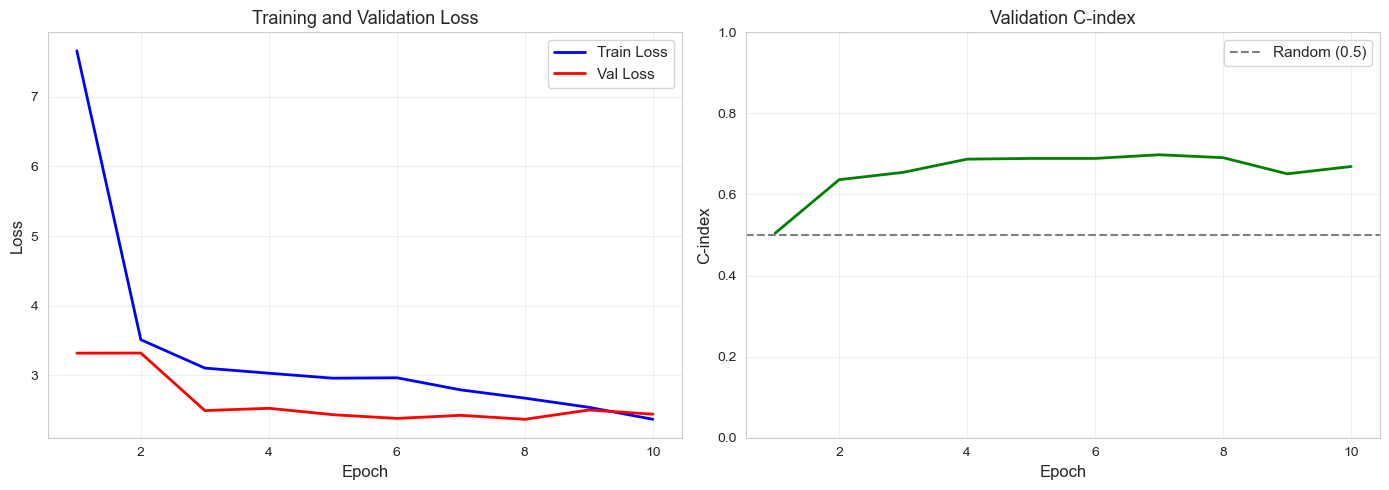


📈 Final Results:
  • Best C-index: 0.6980
  • Final C-index: 0.6691
  • Improvement over random: 33.8%


In [10]:
# Visualize training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# C-index curve
ax2.plot(epochs, history['val_c_index'], 'g-', linewidth=2)
ax2.axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('C-index', fontsize=12)
ax2.set_title('Validation C-index', fontsize=13)
ax2.set_ylim(0, 1)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Final Results:")
print(f"  • Best C-index: {max(history['val_c_index']):.4f}")
print(f"  • Final C-index: {history['val_c_index'][-1]:.4f}")
print(f"  • Improvement over random: {(history['val_c_index'][-1] - 0.5) / 0.5 * 100:.1f}%")

---

## Summary and Key Takeaways

### What We Learned

1. **C-index Fundamentals**:
   - Measures ranking quality for survival predictions
   - Handles censoring naturally
   - Interpretable as pairwise concordance probability

2. **Research Applications**:
   - Disease progression modeling
   - Treatment response prediction
   - Adverse event forecasting
   - Competing risks analysis
   - Resource utilization planning

3. **Labeling Strategies**:
   - Define clear event criteria
   - Establish time origin
   - Handle censoring appropriately
   - Avoid temporal leakage

4. **Complete Workflow**:
   - Load and preprocess EHR data
   - Generate or extract survival labels
   - Train discrete-time survival LSTM
   - Evaluate with C-index

### Next Steps

- **Continuous-time models**: Cox proportional hazards with LSTMs
- **Competing risks**: Multi-event survival modeling
- **Multi-state models**: Complex disease progression pathways
- **Pretrained embeddings**: Med2Vec, BEHRT for better representations
- **Interpretability**: Understanding which features drive risk predictions

### References

- Harrell et al. (1982): "Evaluating the Yield of Medical Tests" - Original C-index paper
- Lee et al. (2018): "DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks"
- Katzman et al. (2018): "DeepSurv: Personalized Treatment Recommender System Using A Cox Proportional Hazards Deep Neural Network"
- Our documentation: `docs/methods/causal-survival-analysis-1.md` and `causal-survival-analysis-2.md`